<a href="https://colab.research.google.com/github/robinanwyl/oud_transcriptomics/blob/main/BENG204_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 204 Project: Understanding Transcriptional Responses to Opioid Exposure Across Neurodevelopmental Stages in Brain Organoid Models

## Notebook Setup

Run this cell every time the notebook is opened to mount the drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If any import statements cannot be resolved, run this cell to re-install those packages.

In [ ]:
%pip install scanpy
%pip install anndata
%pip install igraph
%pip install pydeseq2
#%pip install gseapy

Import statements

In [3]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import random
from scipy.stats import median_abs_deviation
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
# etc.

## Read in Kim et al scRNA-seq 10X output files and save as .h5ad.gz files (perform once)

**Read in the scRNA-seq data for Kim et al dataset day 53 untreated sample and day 53 acute fentanyl treatment sample, add metadata and prepend cell barcodes with unique identifiers, and save each sample as a separate `.h5ad.gz` file. Then merge the datasets and save the merged dataset as a `h5ad.gz` file as well.**

The original sample IDs are KH001 for the day 53 untreated sample and KH002 for the day 53 acute fentanyl treatment sample. Each sample has its own folder containing 3 compressed (`.gz`) files, which are the 10X Genomics CellRanger output files:

*   `matrix.mtx.gz` is a count matrix where rows are single cells, columns are genes, and each cell is the read count of that gene in that cell
*   `barcodes.tsv.gz` contains the cell barcodes (each cell is labeled with a unique barcode, which is used as an identifier)
*   `features.tsv.gz` contains the gene names

For each of the 2 samples, we will first use `scanpy.read_10x_mtx()` to read the 3 files into a single `AnnData` object that contains the cell-by-gene matrix and associated metadata (`obs` = barcodes, `var` = features). We will add columns to the `obs` attribute, `Sample` indicating the sample name and `condition` indicating the treatment group of the sample (untreated or fentanyl). In preparation for merging these samples into one `AnnData` object later, we will prepend the cell barcodes with a sample description, "d53_ut" for untreated samples and "d53_fty" for treated samples. Then we will save each sample `AnnData` object as a compressed `.h5ad.gz` file for later use.

In [ ]:
# sample1_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH001_Day53_Untreated"
# adata1 = sc.read_10x_mtx(sample1_path, var_names="gene_symbols", cache=True)
# adata1.obs["Sample"] = "kim_day53_untreated"
# adata1.obs["condition"] = "untreated"
# adata1.obs.index = [f"d53_ut_{barcode}" for barcode in adata1.obs.index]
# adata1.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ut.h5ad.gz", compression="gzip")

# sample2_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH002_Day53_FTY_Acute"
# adata2 = sc.read_10x_mtx(sample2_path, var_names="gene_symbols", cache=True)
# adata2.obs["Sample"] = "kim_d53_fty_acute"
# adata2.obs["condition"] = "untreated"
# adata2.obs.index = [f"d53_fty_{barcode}" for barcode in adata2.obs.index]
# adata2.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_fty.h5ad.gz", compression="gzip")

Now we will merge the two samples into one `AnnData` object and save the merged dataset as a `.h5ad.gz` file as well.

In [ ]:
# adata_combined = sc.concat([adata1, adata2], label="orig_sample", keys=["sample1", "sample2"])
# adata_combined.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz", compression="gzip")

## QC and preprocessing on Kim et al scRNA-seq dataset

We will read in the Kim et al combined dataset as an `AnnData` object using `scanpy.read_h5ad()`.

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz")

Before QC and preprocessing, we will create a `counts` layer in the `AnnData` object to store the raw counts.

In [ ]:
kim_d53.layers["counts"] = kim_d53.X.copy()

We will begin QC by calculating common QC metrics with `scanpy.pp.calculate_qc_metrics()`.


In [ ]:
kim_d53.var["mt"] = kim_d53.var_names.str.startswith("MT-") # mitochondrial genes
sc.pp.calculate_qc_metrics(kim_d53, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)

We will now inspect violin plots for number of genes expressed, total counts per cell, and percentage of counts in mitochondrial genes.

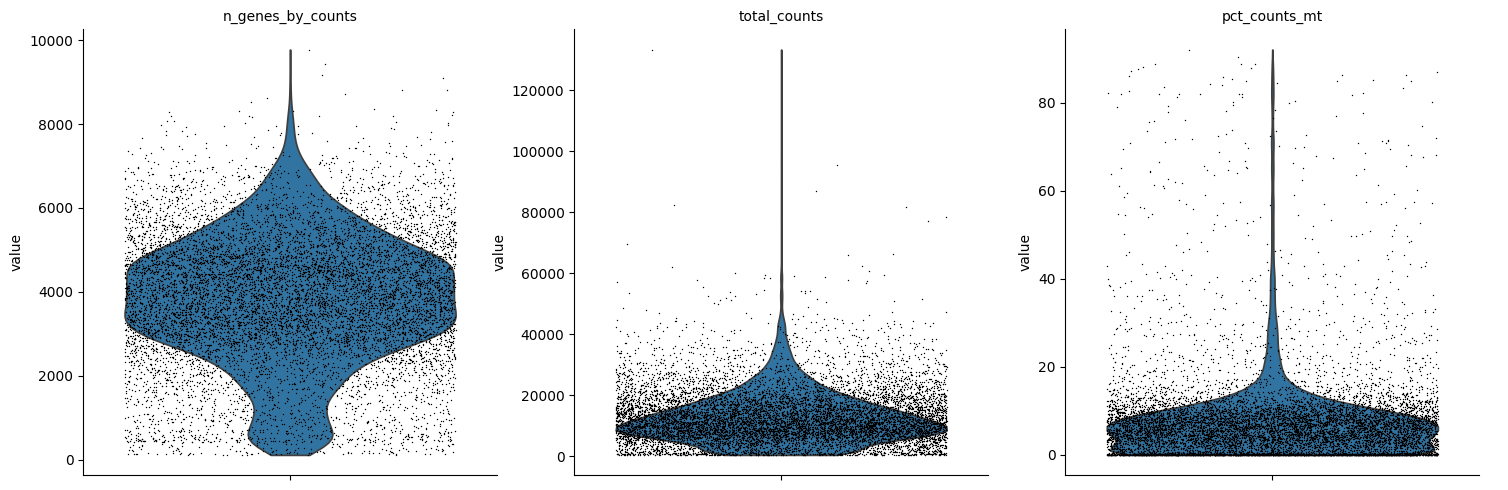

In [ ]:
sc.pl.violin(
    kim_d53,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

We can also inspect a joint scatterplot of all 3 metrics.

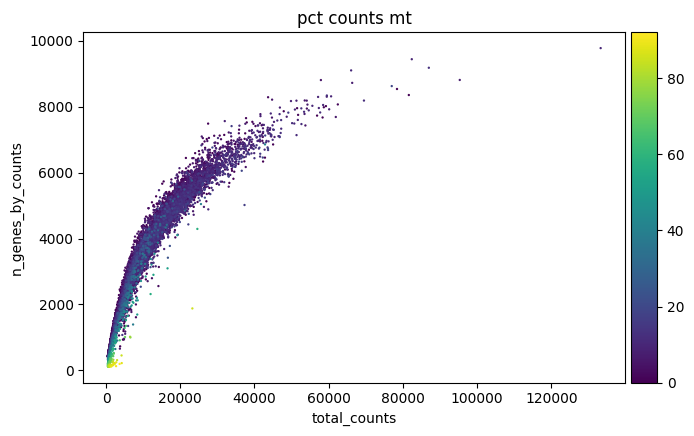

In [ ]:
sc.pl.scatter(kim_d53, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

To filter out low-quality cells, we will use automatic thresholding via MAD (median absolute deviations) following the [Single-Cell Best Practices](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) tutorial. We will mark cells as outliers if they differ by 3 MADs, as recommended by [Basics of Single-Cell Analysis with Bioconductor](https://bioconductor.org/books/3.13/OSCA.basic/quality-control.html). For filtering out cells with a high percentage of mitochondrial genes, we will use 3 MADs. We will also manually set a threshold to filter out cells with >20% mitochondrial genes, consistent with brain organoid transcriptomic studies [Vertesy et al (2022)](https://www.embopress.org/doi/full/10.15252/embj.2022111118) and [Fleck et al (2023)](https://www.nature.com/articles/s41586-022-05279-8).

In [ ]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

kim_d53.obs["outlier"] = (
    is_outlier(kim_d53, "log1p_total_counts", 3)
    | is_outlier(kim_d53, "log1p_n_genes_by_counts", 3)
    | is_outlier(kim_d53, "pct_counts_in_top_20_genes", 3)
    | is_outlier(kim_d53, "pct_counts_mt", 3)
    | (kim_d53.obs["pct_counts_mt"] > 20)
)
kim_d53.obs.outlier.value_counts()

,count
outlier,
False,8631
True,1999


Apply the thresholds:

In [ ]:
kim_d53 = kim_d53[~kim_d53.obs.outlier].copy()

Lastly, we will perform doublet detection with `scanpy.pp.scrublet()` so that we can filter out doublets later if desired.

In [ ]:
sc.pp.scrublet(kim_d53, batch_key="Sample")

We will save the `AnnData` object with the cell barcodes and genes that passed QC as a `.h5ad.gz` file.

In [ ]:
# kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz", compression="gzip")

## Pseudobulk representation and differential expression analysis on Kim et al scRNA-seq dataset

Now we will perform differential expression analysis using `PyDESeq2`. First, read in the QC-passed `AnnData` object:

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz")

The following function creates a pseudobulk representation of a multi-sample `AnnData` object. Each sample is randomly split into a given number of pseudoreplicates.

In [ ]:
def pseudobulk_with_pseudoreps(adata, n):
  """
  Generate the pseudobulk representation of adata with n pseudoreplicates per
  sample, using randomly chosen cells for each pseudoreplicate.
  """
  all_pseudoreps = list()
  for sample in adata.obs.Sample.unique():
    # Get sample cell subset
    samp_cell_subset = adata[adata.obs.Sample == sample]
    # Use raw data
    if "counts" in samp_cell_subset.layers:
      samp_cell_subset.X = samp_cell_subset.layers["counts"]
    # Split indices into n random pseudoreplicates
    indices = list(samp_cell_subset.obs_names)
    random.shuffle(indices)
    indices = np.array_split(np.array(indices), n)
    # Create a single-row AnnData object for each pseudoreplicate
    for i, pseudo_rep in enumerate(indices):
      X = samp_cell_subset[indices[i]].X.sum(axis = 0)
      rep_adata = sc.AnnData(X = np.asarray(samp_cell_subset[indices[i]].X.sum(axis = 0)),
                            var = samp_cell_subset[indices[i]].var[[]])
      rep_adata.obs_names = [sample + '_' + str(i)]
      rep_adata.obs['condition'] = samp_cell_subset.obs['condition'].iloc[0]
      rep_adata.obs['replicate'] = i
      all_pseudoreps.append(rep_adata)
  # Combine all pseudoreplicates into one AnnData object
  pseudobulk = sc.concat(all_pseudoreps)
  return pseudobulk

We will generate a pseudobulk dataset with 3 pseudoreplicates.

In [ ]:
sc.pp.filter_genes(kim_d53, min_cells=10)
random.seed(42)
pb3 = pseudobulk_with_pseudoreps(kim_d53, 3)

Now will create a `DeseqDataSet` object from the pseudobulk dataset. Then we will fit dispersions and log-fold-changes (LFCs) for differential expression analysis.

In [ ]:
dds3 = DeseqDataSet(adata=pb3, design="~condition")
dds3.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 25.14 seconds.

Fitting dispersion trend curve...
... done in 0.61 seconds.

Fitting MAP dispersions...
... done in 27.64 seconds.

Fitting LFCs...
... done in 18.27 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



Now we will perform statistical testing to compare the fentanyl condition to the untreated condition.

In [ ]:
dstats3 = DeseqStats(dds3, contrast=["condition", "fentanyl", "untreated"])
dstats3.summary()

Running Wald tests...
... done in 10.30 seconds.



Log2 fold change & Wald test p-value: condition fentanyl vs untreated
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.1    9.618501        0.220310  0.587052  0.375282  0.707451       NaN
AL669831.5  377.429062       -0.233587  0.095359 -2.449547  0.014304  0.067920
FAM87B        2.159294       -0.649988  1.219305 -0.533081  0.593978       NaN
LINC00115    67.584534       -0.300061  0.208096 -1.441938  0.149320  0.347000
FAM41C       48.168095        0.452386  0.265578  1.703404  0.088493  0.245626
...                ...             ...       ...       ...       ...       ...
AC136352.3    2.151529        0.237125  1.168972  0.202849  0.839253       NaN
AC011043.1  195.049524       -0.137836  0.125135 -1.101496  0.270681  0.498924
AC007325.4  184.022373       -0.015923  0.131585 -0.121008  0.903684  0.954524
AC004556.1  439.698326        0.275083  0.083657  3.288236  0.001008  0.008865
AC240274.1  165.576144        0.125439  0.138969  0.902641  0

In [ ]:
ds3_df = dstats3.results_df
ds3_df.sort_values('log2FoldChange', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NNAT,78.716121,5.462854,0.769964,-7.346734,2.031080e-13,2.437296e-11
TNK2-AS1,29.630362,3.795253,1.500814,-3.459724,5.407298e-04,NaN
DLX6-AS1,6.576621,2.944983,0.968079,-3.495222,4.736667e-04,NaN
SP8,5.101488,2.371651,0.989000,-3.058516,2.224365e-03,NaN
AC211486.2,5.977244,2.273922,0.907215,-3.184628,1.449404e-03,NaN
...,...,...,...,...,...,...
SP5,19.807448,-2.026336,0.476181,4.802690,1.565481e-06,NaN
CYP1B1,8.335949,-2.733761,0.817727,3.924656,8.685379e-05,NaN
EN1,75.146823,-3.864528,0.500891,8.023140,1.030758e-15,1.793520e-13
MAGEA12,3.842754,-5.153906,2.478191,2.589427,9.613586e-03,NaN


In [ ]:
ds3_df.sort_values('padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ACTB,60566.016066,-0.302687,0.019817,15.398460,1.676125e-53,2.333166e-49
SRSF3,8769.080914,-0.345040,0.023442,14.855442,6.414382e-50,4.464410e-46
MT-ATP6,160821.129014,-0.269801,0.018412,14.774396,2.142694e-49,9.942098e-46
PAX6,344.909756,1.447283,0.101427,-14.427169,3.491208e-47,1.214940e-43
BDNF,1431.725071,-0.820358,0.058950,14.091369,4.291630e-45,1.194790e-41
...,...,...,...,...,...,...
AP001468.1,2.004573,-0.006950,0.132450,0.824695,4.095447e-01,NaN
AP001469.1,2.499221,0.004951,0.150802,-0.519175,6.036387e-01,NaN
AP001469.2,1.995215,0.003238,0.149650,-0.381490,7.028399e-01,NaN
AP001469.3,28.241397,0.004292,0.132881,-0.149205,8.813922e-01,NaN


We will perform LFC shrinkage to shrink LFCs of cells with low information.

In [ ]:
dstats3.lfc_shrink(coeff="condition[T.untreated]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.untreated]
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.1    9.618501       -0.006408  0.137509  0.375282  0.707451       NaN
AL669831.5  377.429062        0.171457  0.096802 -2.449547  0.014304  0.067920
FAM87B        2.159294        0.004537  0.153105 -0.533081  0.593978       NaN
LINC00115    67.584534        0.068037  0.146210 -1.441938  0.149320  0.347000
FAM41C       48.168095       -0.069284  0.156719  1.703404  0.088493  0.245626
...                ...             ...       ...       ...       ...       ...
AC136352.3    2.151529       -0.001776  0.140079  0.202849  0.839253       NaN
AC011043.1  195.049524        0.060379  0.104331 -1.101496  0.270681  0.498924
AC007325.4  184.022373        0.006027  0.097346 -0.121008  0.903684  0.954524
AC004556.1  439.698326       -0.231393  0.085513  3.288236  0.001008  0.008865
AC240274.1  165.576144       -0.046653  0.106684  0.902641  0.3

... done in 36.23 seconds.



In [ ]:
ds3_df = dstats3.results_df
ds3_df.sort_values('log2FoldChange', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NNAT,78.716121,5.462854,0.769964,-7.346734,2.031080e-13,2.437296e-11
TNK2-AS1,29.630362,3.795253,1.500814,-3.459724,5.407298e-04,NaN
DLX6-AS1,6.576621,2.944983,0.968079,-3.495222,4.736667e-04,NaN
SP8,5.101488,2.371651,0.989000,-3.058516,2.224365e-03,NaN
AC211486.2,5.977244,2.273922,0.907215,-3.184628,1.449404e-03,NaN
...,...,...,...,...,...,...
SP5,19.807448,-2.026336,0.476181,4.802690,1.565481e-06,NaN
CYP1B1,8.335949,-2.733761,0.817727,3.924656,8.685379e-05,NaN
EN1,75.146823,-3.864528,0.500891,8.023140,1.030758e-15,1.793520e-13
MAGEA12,3.842754,-5.153906,2.478191,2.589427,9.613586e-03,NaN


In [ ]:
ds3_df.sort_values('padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ACTB,60566.016066,-0.302687,0.019817,15.398460,1.676125e-53,2.333166e-49
SRSF3,8769.080914,-0.345040,0.023442,14.855442,6.414382e-50,4.464410e-46
MT-ATP6,160821.129014,-0.269801,0.018412,14.774396,2.142694e-49,9.942098e-46
PAX6,344.909756,1.447283,0.101427,-14.427169,3.491208e-47,1.214940e-43
BDNF,1431.725071,-0.820358,0.058950,14.091369,4.291630e-45,1.194790e-41
...,...,...,...,...,...,...
AP001468.1,2.004573,-0.006950,0.132450,0.824695,4.095447e-01,NaN
AP001469.1,2.499221,0.004951,0.150802,-0.519175,6.036387e-01,NaN
AP001469.2,1.995215,0.003238,0.149650,-0.381490,7.028399e-01,NaN
AP001469.3,28.241397,0.004292,0.132881,-0.149205,8.813922e-01,NaN


We are seeing absurdly low p-values and high LFCs, likely due to the inflated statistical power of the pseudoreplicates. To generate preliminary results, we will instead perform differential expression analysis on the single-cell data rather than on a pseudobulk representation.

## Differential expression analysis on Kim et al scRNA-seq data

Read in the QC-passed `AnnData` object:

In [4]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz")

Normalize the data (count depth scaling followed by subsequent log1p transformation):

In [5]:
sc.pp.normalize_total(kim_d53)
sc.pp.log1p(kim_d53)

Identify highly variable genes (feature selection), which we will use for further analysis:

In [6]:
sc.pp.highly_variable_genes(kim_d53, n_top_genes=2000, batch_key="Sample")

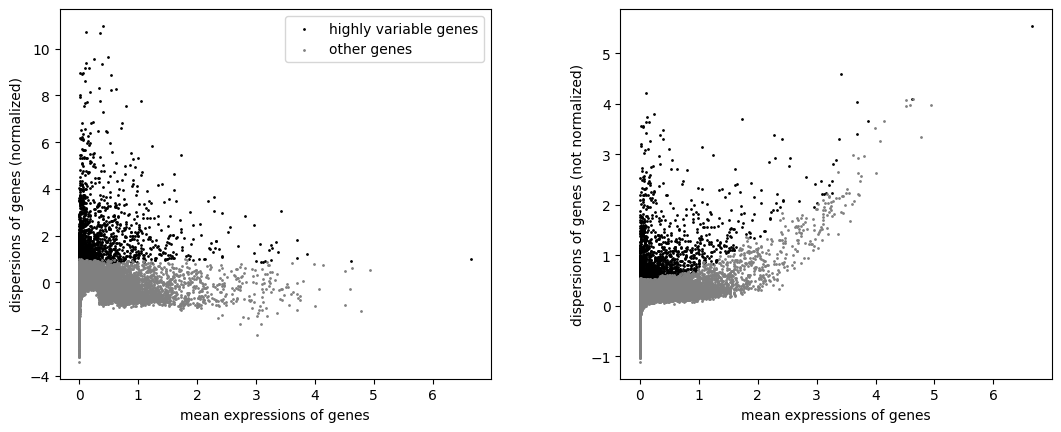

In [ ]:
sc.pl.highly_variable_genes(kim_d53)

Perform principal component analysis (PCA), a linear dimensionality reduction method:

In [34]:
sc.tl.pca(kim_d53, use_highly_variable=True)

View the elbow plot that displays the contribution of each principal component (PC) to total variance in the data:

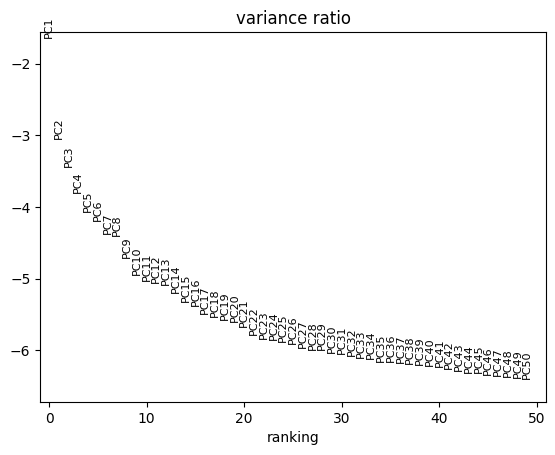

In [35]:
sc.pl.pca_variance_ratio(kim_d53, n_pcs=50, log=True)

Plot the first four PCs for each sample to check for unwanted sources of variance:

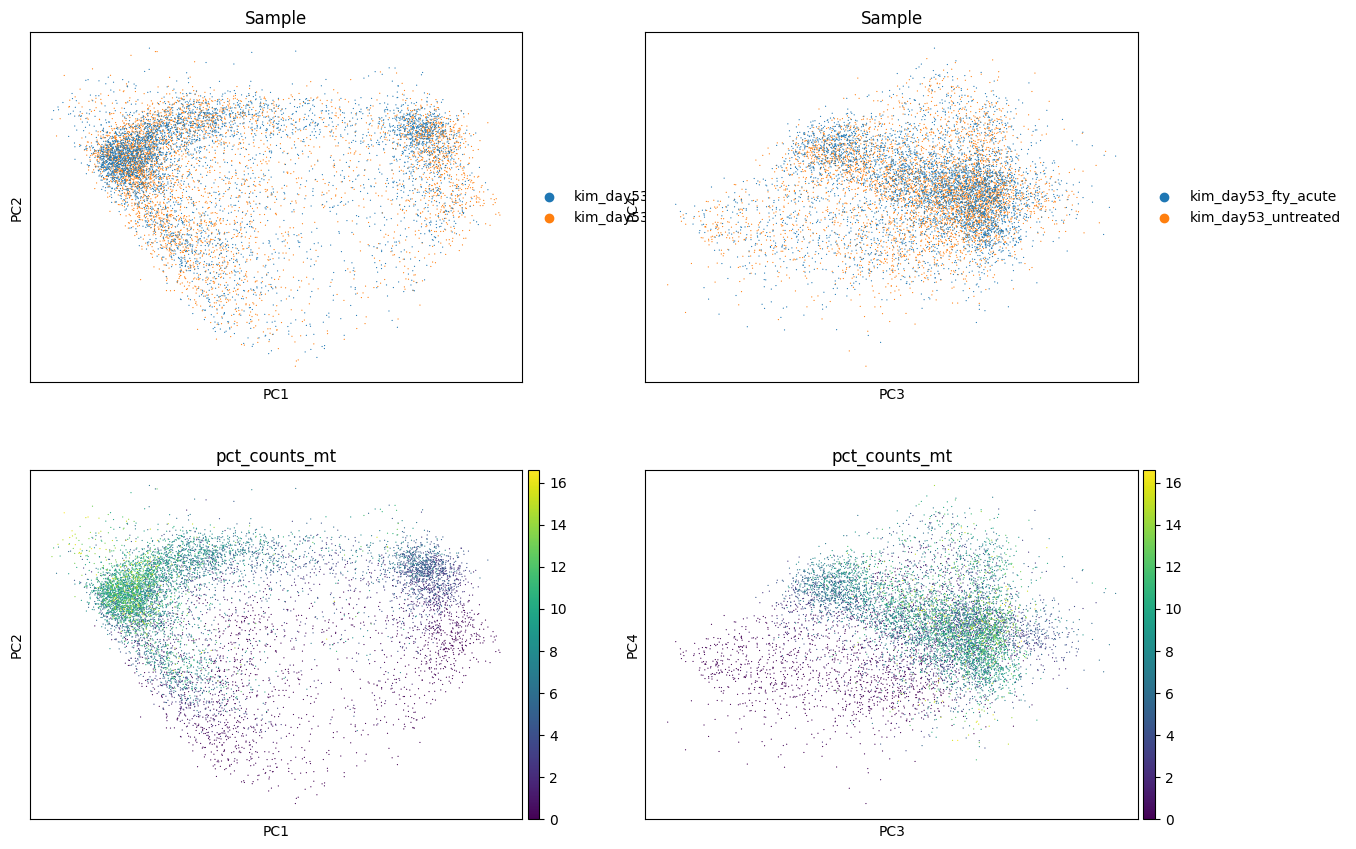

In [26]:
sc.pl.pca(
    kim_d53,
    color=["Sample", "Sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=3,
)

Based on the elbow plot, we will use the first 22 PCs for further analysis. Now we compute the k-nearest neighbors and embed the neighborhood graph in 2 dimensions for UMAP visualization:

In [36]:
sc.pp.neighbors(kim_d53, n_pcs = 22)
sc.tl.umap(kim_d53, n_components = 22)

Visualize the UMAP:

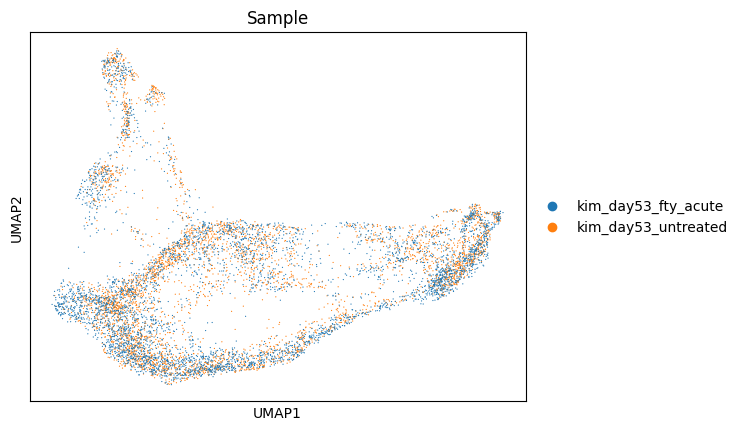

In [37]:
sc.pl.umap(
    kim_d53,
    color="Sample",
    size=3
)

Perform Leiden clustering and visualize the UMAP again:

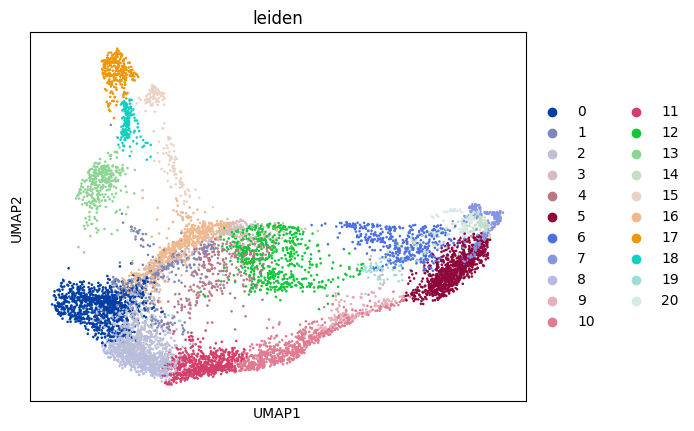

In [38]:
sc.tl.leiden(kim_d53, flavor="igraph", n_iterations=2)
sc.pl.umap(kim_d53, color=["leiden"])

### Differential Expression Analysis with `scanpy.tl.rank_genes_groups()`

Compute a ranking for the highly differential genes **in each cluster**, using the Wilcoxon rank-sum method:

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

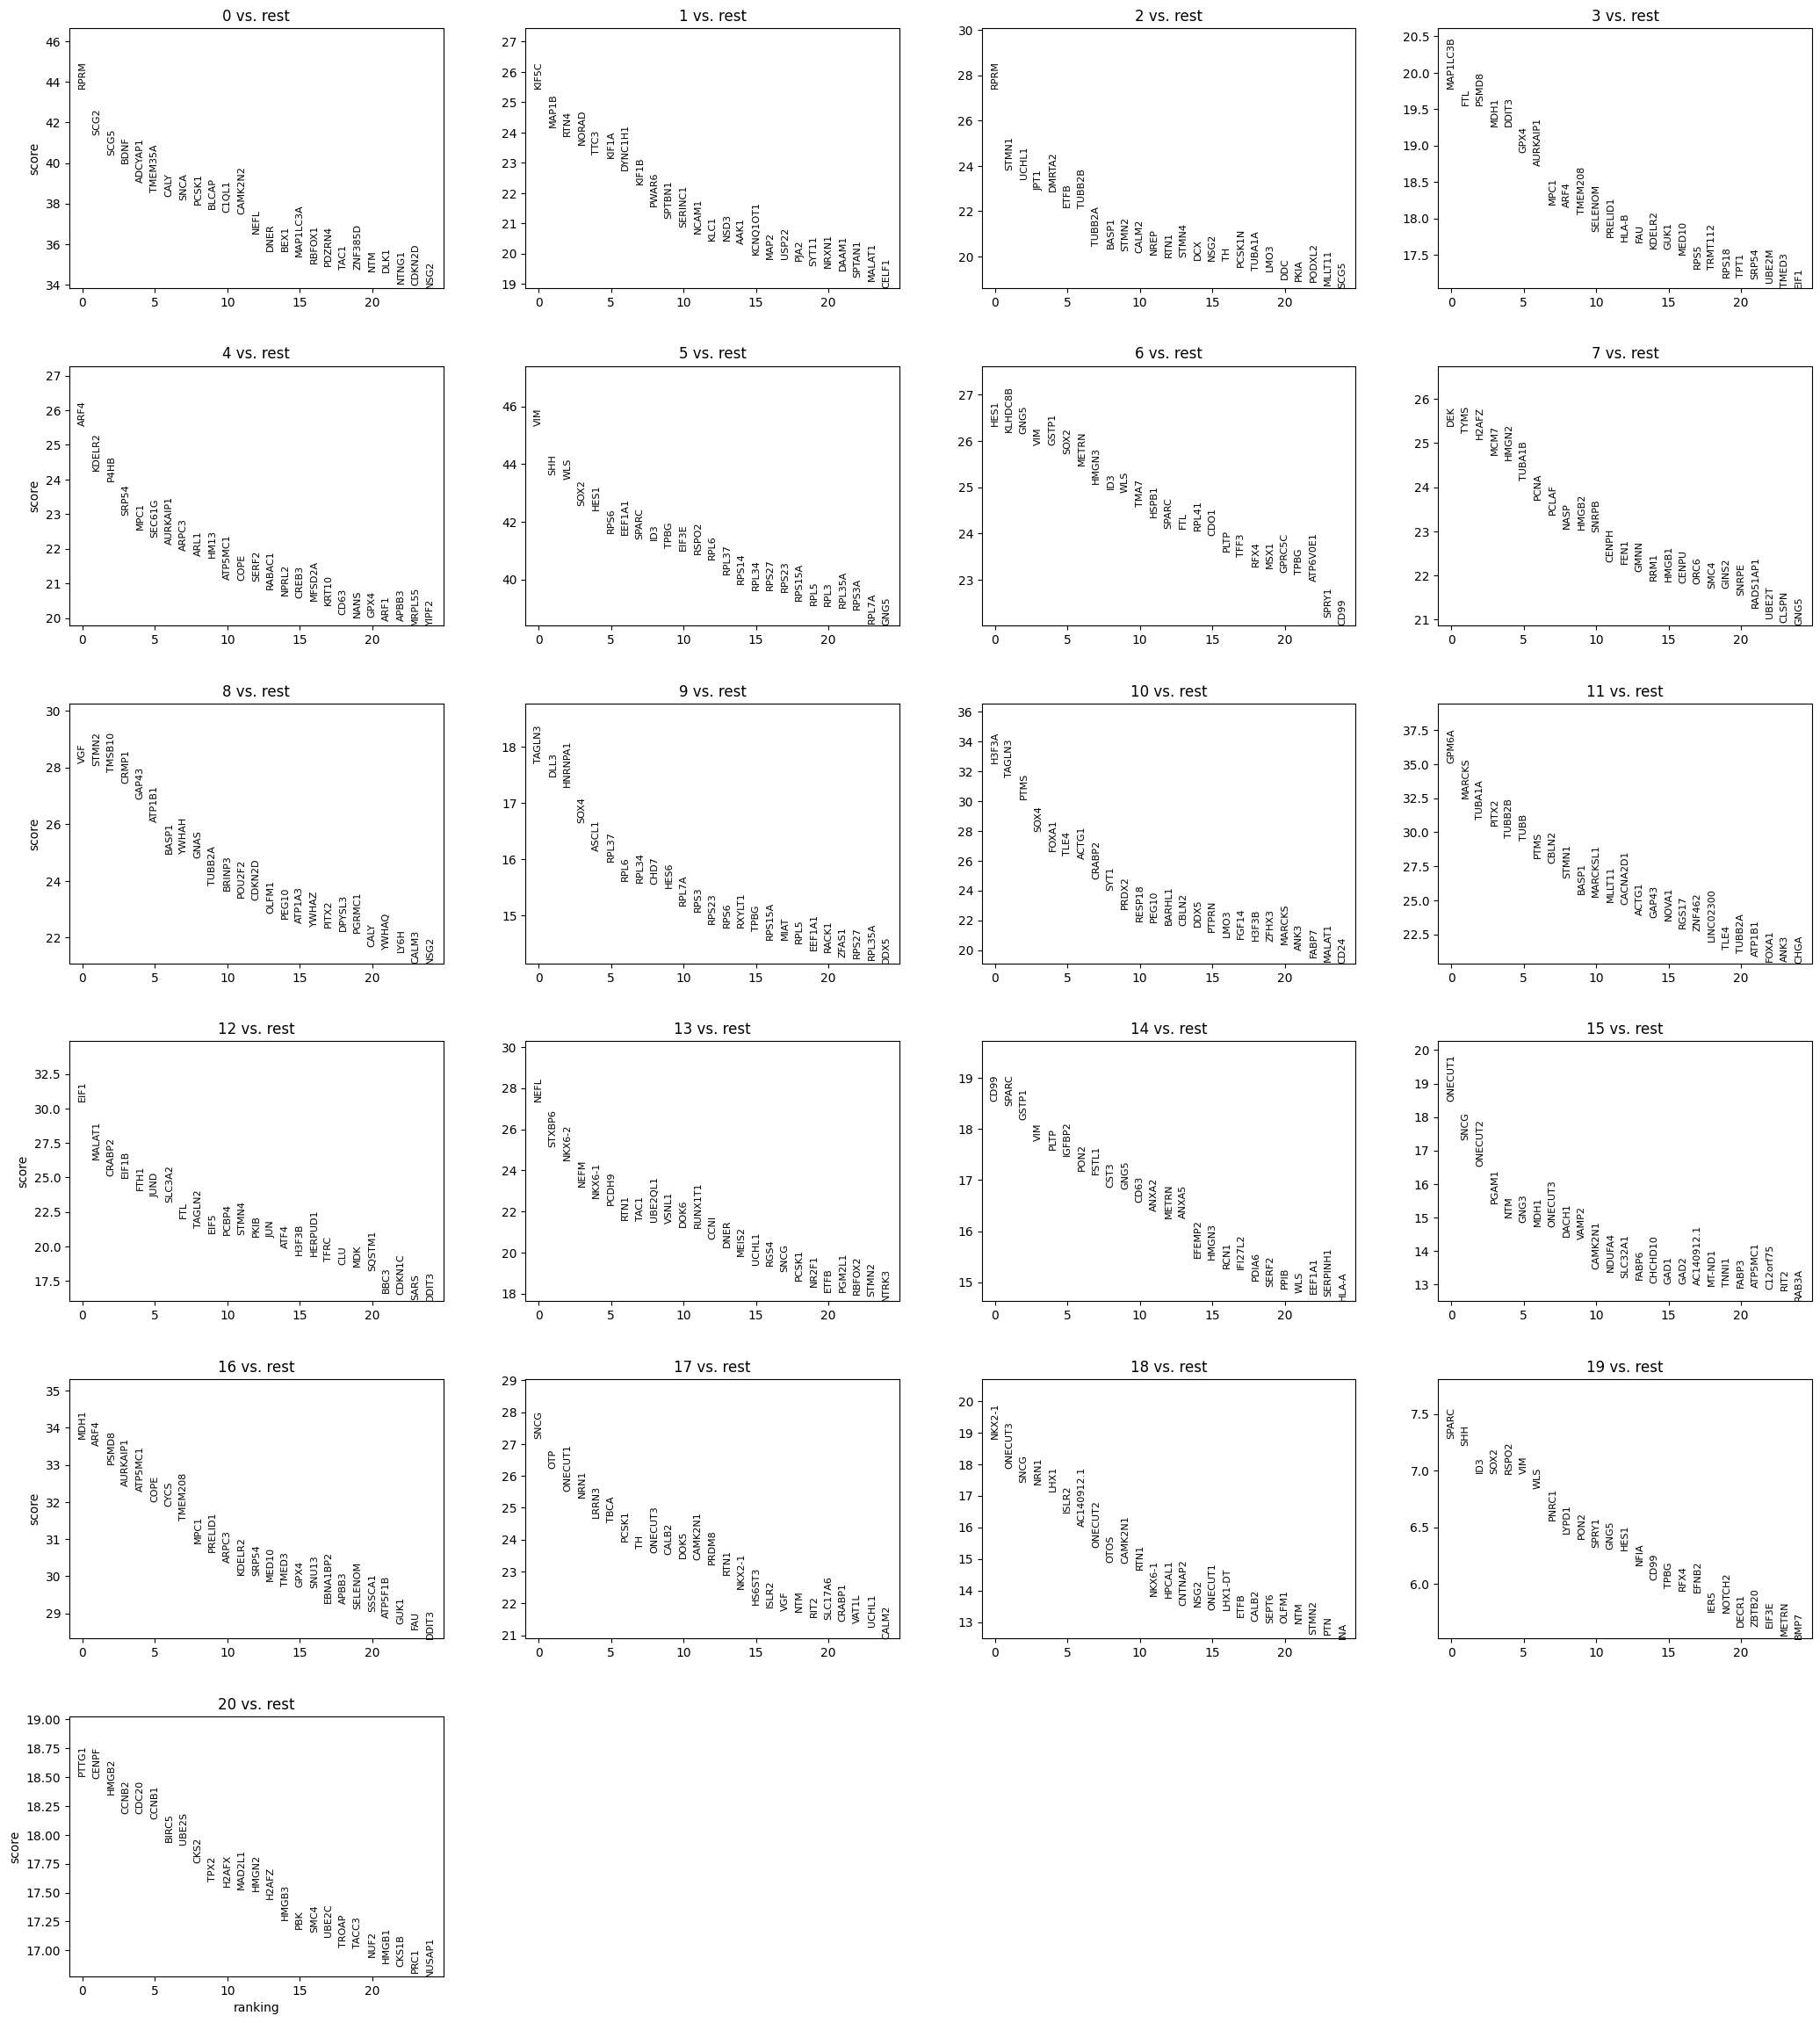

In [52]:
sc.tl.rank_genes_groups(kim_d53, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(kim_d53, n_genes=25, sharey=False)

Display the top 5 differentially expressed genes per cluster in a table:

In [53]:
pd.set_option('display.max_columns', None)
pd.DataFrame(kim_d53.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,RPRM,KIF5C,RPRM,MAP1LC3B,ARF4,VIM,HES1,DEK,VGF,TAGLN3,H3F3A,GPM6A,EIF1,NEFL,CD99,ONECUT1,MDH1,SNCG,NKX2-1,SPARC,PTTG1
1,SCG2,MAP1B,STMN1,FTL,KDELR2,SHH,KLHDC8B,TYMS,STMN2,DLL3,TAGLN3,MARCKS,MALAT1,STXBP6,SPARC,SNCG,ARF4,OTP,ONECUT3,SHH,CENPF
2,SCG5,RTN4,UCHL1,PSMD8,P4HB,WLS,GNG5,H2AFZ,TMSB10,HNRNPA1,PTMS,TUBA1A,CRABP2,NKX6-2,GSTP1,ONECUT2,PSMD8,ONECUT1,SNCG,ID3,HMGB2
3,BDNF,NORAD,JPT1,MDH1,SRP54,SOX2,VIM,MCM7,CRMP1,SOX4,SOX4,PITX2,EIF1B,NEFM,VIM,PGAM1,AURKAIP1,NRN1,NRN1,SOX2,CCNB2
4,ADCYAP1,TTC3,DMRTA2,DDIT3,MPC1,HES1,GSTP1,HMGN2,GAP43,ASCL1,FOXA1,TUBB2B,FTH1,NKX6-1,PLTP,NTM,ATP5MC1,LRRN3,LHX1,RSPO2,CDC20


Display a table of differentially expressed genes with scores and groups:

In [54]:
pd.set_option('display.max_columns', None)
result = kim_d53.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p,16_n,16_p,17_n,17_p,18_n,18_p,19_n,19_p,20_n,20_p
0,RPRM,0.0,KIF5C,4.687046e-143,RPRM,1.146273e-165,MAP1LC3B,3.716856e-87,ARF4,5.241108e-144,VIM,0.0,HES1,1.017608e-152,DEK,3.359047e-142,VGF,3.193706e-174,TAGLN3,3.628222e-70,H3F3A,3.406991e-232,GPM6A,3.248528e-269,EIF1,7.810317e-205,NEFL,6.526072e-165,CD99,9.068017e-77,ONECUT1,3.193975e-76,MDH1,4.906544e-249,SNCG,1.759646e-162,NKX2-1,6.913160e-79,SPARC,3.300719e-13,PTTG1,1.864250e-76
1,SCG2,0.0,MAP1B,3.496339e-129,STMN1,4.055290e-125,FTL,3.771908e-85,KDELR2,4.663599e-130,SHH,0.0,KLHDC8B,4.242281e-151,TYMS,2.235062e-140,STMN2,4.810782e-173,DLL3,2.247415e-68,TAGLN3,2.834217e-219,MARCKS,1.342204e-231,MALAT1,1.694520e-152,STXBP6,3.306094e-139,SPARC,4.551023e-76,SNCG,4.352515e-67,ARF4,2.924379e-246,OTP,8.583544e-152,ONECUT3,2.577876e-71,SHH,5.322280e-13,CENPF,2.519875e-76
2,SCG5,0.0,RTN4,4.238294e-126,UCHL1,3.908957e-121,PSMD8,3.934014e-85,P4HB,9.856492e-127,WLS,0.0,GNG5,7.505145e-151,H2AFZ,7.254570e-139,TMSB10,1.025876e-170,HNRNPA1,5.576800e-67,PTMS,1.676947e-199,TUBA1A,5.945350e-210,CRABP2,6.405035e-139,NKX6-2,1.772020e-132,GSTP1,7.509288e-74,ONECUT2,2.381005e-61,PSMD8,3.535124e-239,ONECUT1,1.037025e-143,SNCG,6.766729e-68,ID3,3.008308e-12,HMGB2,3.488463e-75
3,BDNF,0.0,NORAD,3.917743e-123,JPT1,2.257280e-116,MDH1,1.000732e-82,SRP54,9.703089e-117,SOX2,0.0,VIM,5.757409e-148,MCM7,4.822968e-135,CRMP1,9.376881e-166,SOX4,2.891073e-62,SOX4,4.274090e-172,PITX2,2.161956e-204,EIF1B,5.274751e-138,NEFM,4.463142e-119,VIM,1.161006e-70,PGAM1,1.312183e-53,AURKAIP1,9.710611e-231,NRN1,1.869978e-141,NRN1,1.347197e-67,SOX2,3.058392e-12,CCNB2,6.835871e-74
4,ADCYAP1,0.0,TTC3,6.280484e-120,DMRTA2,1.041245e-115,DDIT3,1.068870e-82,MPC1,1.426324e-112,HES1,0.0,GSTP1,6.296774e-148,HMGN2,9.428375e-134,GAP43,5.420922e-159,ASCL1,1.081782e-58,FOXA1,2.218094e-156,TUBB2B,2.769555e-192,FTH1,4.513164e-128,NKX6-1,1.489656e-113,PLTP,2.876019e-69,NTM,7.696076e-51,ATP5MC1,8.925292e-229,LRRN3,1.181486e-134,LHX1,9.708812e-66,RSPO2,3.085615e-12,CDC20,7.260098e-74


Compute a ranking for the highly differential genes **in each sample**:

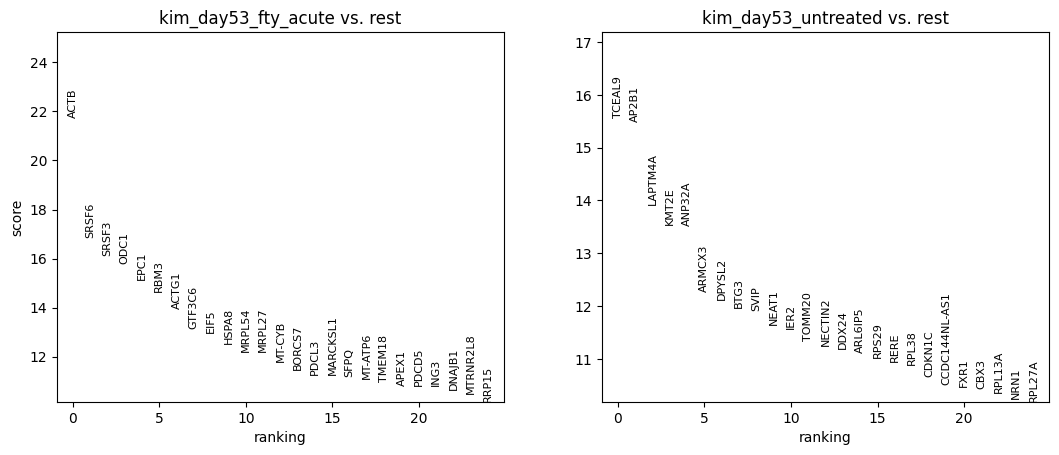

In [44]:
sc.tl.rank_genes_groups(kim_d53, "Sample", method="wilcoxon")
sc.pl.rank_genes_groups(kim_d53, n_genes=25, sharey=False)

In [46]:
pd.DataFrame(kim_d53.uns["rank_genes_groups"]["names"]).head(10)

,kim_day53_fty_acute,kim_day53_untreated
0,ACTB,TCEAL9
1,SRSF6,AP2B1
2,SRSF3,LAPTM4A
3,ODC1,KMT2E
4,EPC1,ANP32A
5,RBM3,ARMCX3
6,ACTG1,DPYSL2
7,GTF3C6,BTG3
8,EIF5,SVIP
9,HSPA8,NEAT1


In [47]:
result = kim_d53.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(10)

,kim_day53_fty_acute_n,kim_day53_fty_acute_p,kim_day53_untreated_n,kim_day53_untreated_p
0,ACTB,6.237505e-105,TCEAL9,1.131897e-54
1,SRSF6,1.240877e-63,AP2B1,4.324136e-54
2,SRSF3,2.784833e-58,LAPTM4A,4.697878e-44
3,ODC1,4.434673e-56,KMT2E,1.043175e-41
4,EPC1,1.029125e-51,ANP32A,1.192277e-41
5,RBM3,1.878901e-48,ARMCX3,1.278724e-34
6,ACTG1,3.068454e-44,DPYSL2,8.616421e-34
7,GTF3C6,1.513449e-39,BTG3,5.242176e-33
8,EIF5,1.887760e-38,SVIP,1.016760e-32
9,HSPA8,4.294720e-36,NEAT1,2.307643e-31


/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_tools/__init__.py:1331: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


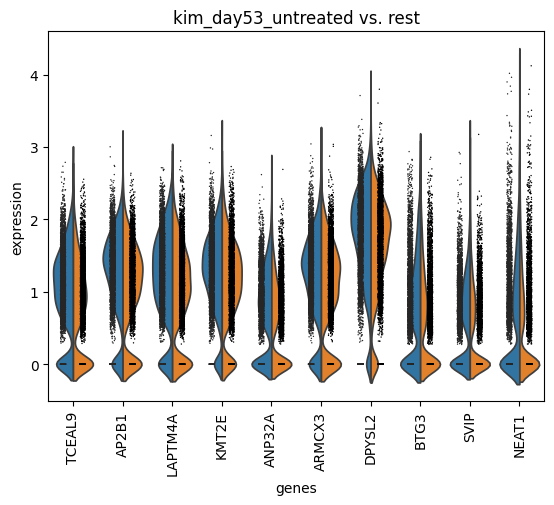

In [49]:
sc.pl.rank_genes_groups_violin(kim_d53, groups="kim_day53_untreated", n_genes=10)

/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_tools/__init__.py:1331: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


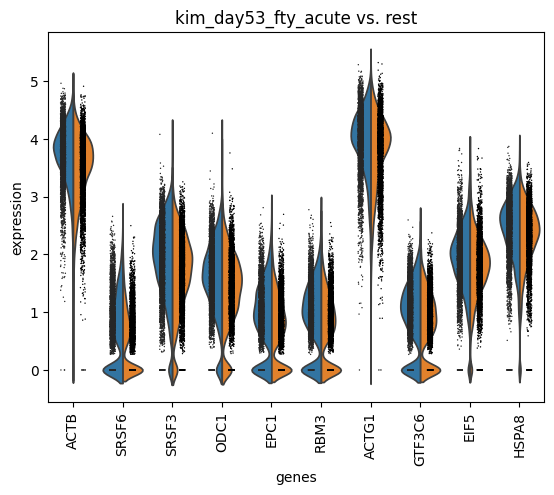

In [50]:
sc.pl.rank_genes_groups_violin(kim_d53, groups="kim_day53_fty_acute", n_genes=10)

## Analysis on Ho et al bulk RNA-seq data

First, we read in Ho et al bulk RNA-seq data, which is in the form of a gene-by-sample matrix within a .txt file. We then transpose this matrix into a sample-by-gene matrix, from which we then remove genes that are not expressed in at least 10 cells.

In [ ]:
counts_raw = pd.read_table("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE210206_counts.txt", index_col=0, header=0)
#Transposing data:
counts_df = counts_raw.T
print(f"Number of genes before filtering: {counts_df.shape[1]}")
#Filtering data:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]
print(f"Number of genes after filtering: {counts_df.shape[1]}")
counts_df.head()

Number of genes before filtering: 25370
Number of genes after filtering: 20694


gene_symbol,WASH7P,LOC729737,LOC100133331,MIR6723,LOC100288069,FAM87B,LINC00115,LINC01128,FAM41C,LOC100130417,...,NLGN4Y-AS1,NCRNA00185,TTTY14,CD24,BCORP1,TXLNGY,KDM5D,TTTY10,EIF1AY,RPS4Y2
OFO1003B1,448,137,65,67,40,9,40,503,2,71,...,4,22,23,5745,4,327,702,3,344,2
OFO1003B2,437,121,82,101,42,8,17,512,3,65,...,4,25,23,5750,2,304,745,1,363,0
OFO1003O1,412,116,74,51,34,3,50,206,0,38,...,4,15,8,3522,1,226,470,3,476,0
OFO1003O2,510,110,73,64,28,5,32,242,1,50,...,2,18,13,3924,1,233,569,2,560,1
OFO1003V1,637,184,67,46,47,6,108,427,0,62,...,5,17,25,5973,3,356,761,2,526,0


Now, we read in our sample metadata:

In [ ]:
metadata_Ho = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_metadata.csv", index_col=0)
metadata_Ho.head()

,Condition
Sample,
OFO1003B1,buprenorphine
OFO1003B2,buprenorphine
OFO1003O1,oxycodone
OFO1003O2,oxycodone
OFO1003V1,PBS


Now, we create our `DeseqDataSet` object and then fit said object with dispersions and LFCs for differential expression analysis.

In [ ]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_Ho,
    design="~Condition"
)
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 36.57 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 45.93 seconds.

Fitting LFCs...
... done in 18.00 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.



We will now perform our statistical analyses upon the aforementioned DeseqDataSet by first creating a `DeseqStats` object & then running the `summary()` method.

In [ ]:
ds = DeseqStats(dds, contrast=["Condition", "oxycodone", "PBS"])
ds.summary()

Running Wald tests...
... done in 7.08 seconds.



Log2 fold change & Wald test p-value: Condition oxycodone vs PBS
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
WASH7P        344.202941       -0.021586  0.327446 -0.065923  0.947439   
LOC729737     102.130186       -0.250510  0.316119 -0.792454  0.428096   
LOC100133331   66.223814        0.089953  0.174544  0.515359  0.606302   
MIR6723        65.966132        0.007637  0.233102  0.032763  0.973864   
LOC100288069   41.854978        0.044645  0.191099  0.233622  0.815279   
...                  ...             ...       ...       ...       ...   
TXLNGY        378.969377       -0.020204  0.186730 -0.108199  0.913838   
KDM5D         694.759371       -0.054766  0.081218 -0.674307  0.500116   
TTTY10          3.112367       -0.767770  0.648624 -1.183692  0.236535   
EIF1AY        607.783994        0.298369  0.239899  1.243727  0.213600   
RPS4Y2          0.929605        1.184722  1.365

Here, we perform LFC shrinkage to improve the accuracy of our estimates via shrinking LFC estimates of genes with low information (e.g. low counts or high dispersions) towards 0.

In [ ]:
ds.lfc_shrink(coeff="Condition[T.oxycodone]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Condition[T.oxycodone]
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
WASH7P        344.202941       -0.000782  0.063557 -0.065923  0.947439   
LOC729737     102.130186       -0.010161  0.064603 -0.792454  0.428096   
LOC100133331   66.223814        0.010999  0.061906  0.515359  0.606302   
MIR6723        65.966132        0.000569  0.062428  0.032763  0.973864   
LOC100288069   41.854978        0.004627  0.061568  0.233622  0.815279   
...                  ...             ...       ...       ...       ...   
TXLNGY        378.969377       -0.002112  0.061246 -0.108199  0.913838   
KDM5D         694.759371       -0.022112  0.053306 -0.674307  0.500116   
TTTY10          3.112367       -0.007808  0.065157 -1.183692  0.236535   
EIF1AY        607.783994        0.021386  0.067444  1.243727  0.213600   
RPS4Y2          0.929605        0.002804  0.

... done in 48.83 seconds.



Here, we view the results of the above Wald tests.

In [ ]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
SLC22A8,17.545470,2.905353,0.904686,4.085724,0.000044,0.057740
TMEM72,28.752807,2.665592,0.712462,4.490036,0.000007,0.015206
ATP13A5,58.578079,2.493514,0.896273,3.788270,0.000152,0.097874
AQP1,1627.090430,2.001534,0.716442,3.786702,0.000153,0.097874
CPA4,51.445319,1.997733,0.820159,3.550174,0.000385,0.118537
...,...,...,...,...,...,...
DACH2,48.335752,-1.207924,0.331860,-4.401986,0.000011,0.020360
CYP4X1,45.521659,-1.252895,0.425906,-3.867435,0.000110,0.097874
LINC01106,7.020388,-1.475731,0.549401,-3.599393,0.000319,0.114981


We want to view genes that demonstrate the highest or lowest log2fold changes, but with padj <= 0.05.

---



In [ ]:
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
DEGs_df = ds_df[ds_df["padj"] <= 0.05]
DEGs_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
TMEM72,28.752807,2.665592,0.712462,4.490036,7.121108e-06,0.015206
PTGER2,33.517680,1.533124,0.444303,4.254655,2.093713e-05,0.035767
AGPAT9,114.833434,1.239933,0.329331,4.509245,6.505866e-06,0.015206
TIMP3,1521.537448,0.874927,0.223534,4.630080,3.655247e-06,0.013992
MOSPD1,400.777753,0.627025,0.162526,4.568405,4.914501e-06,0.013992
ICT1,336.556565,0.415894,0.099100,4.833475,1.341704e-06,0.007640
VKORC1,1213.250268,0.256509,0.045891,6.020707,1.736570e-09,0.000030
SRI,1236.440551,0.211202,0.059443,4.161965,3.155211e-05,0.049000
MMP3,83.840282,-0.023353,0.071248,-5.239670,1.608637e-07,0.001374


Now, we export both our results & the differentially expressed genes as .csv files.

In [ ]:
# ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")
# DEGs_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")

## Visualizing Ho et al DEGs

Read in results of statistical analysis

In [ ]:
ds_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")
DEGs_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")
ds_df.head()

,gene_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,SLC22A8,17.545470,2.905353,0.904686,4.085724,0.000044,0.057740
1,TMEM72,28.752807,2.665592,0.712462,4.490036,0.000007,0.015206
2,ATP13A5,58.578079,2.493514,0.896273,3.788270,0.000152,0.097874
3,AQP1,1627.090430,2.001534,0.716442,3.786702,0.000153,0.097874
4,CPA4,51.445319,1.997733,0.820159,3.550174,0.000385,0.118537


We will add a column to the results `DataFrame` indicating whether a gene is non-significant (ns), significant and increases in expression (up), or significant and decreases in expression (down).

In [ ]:
ds_df["significance"] = np.where(ds_df["padj"] > 0.05, "ns", np.where(ds_df["log2FoldChange"] > 0, "up", "down"))

We will save the results DataFrame:


In [ ]:
#ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")

We now plot the log2 fold-change versus mean expression between both conditions.

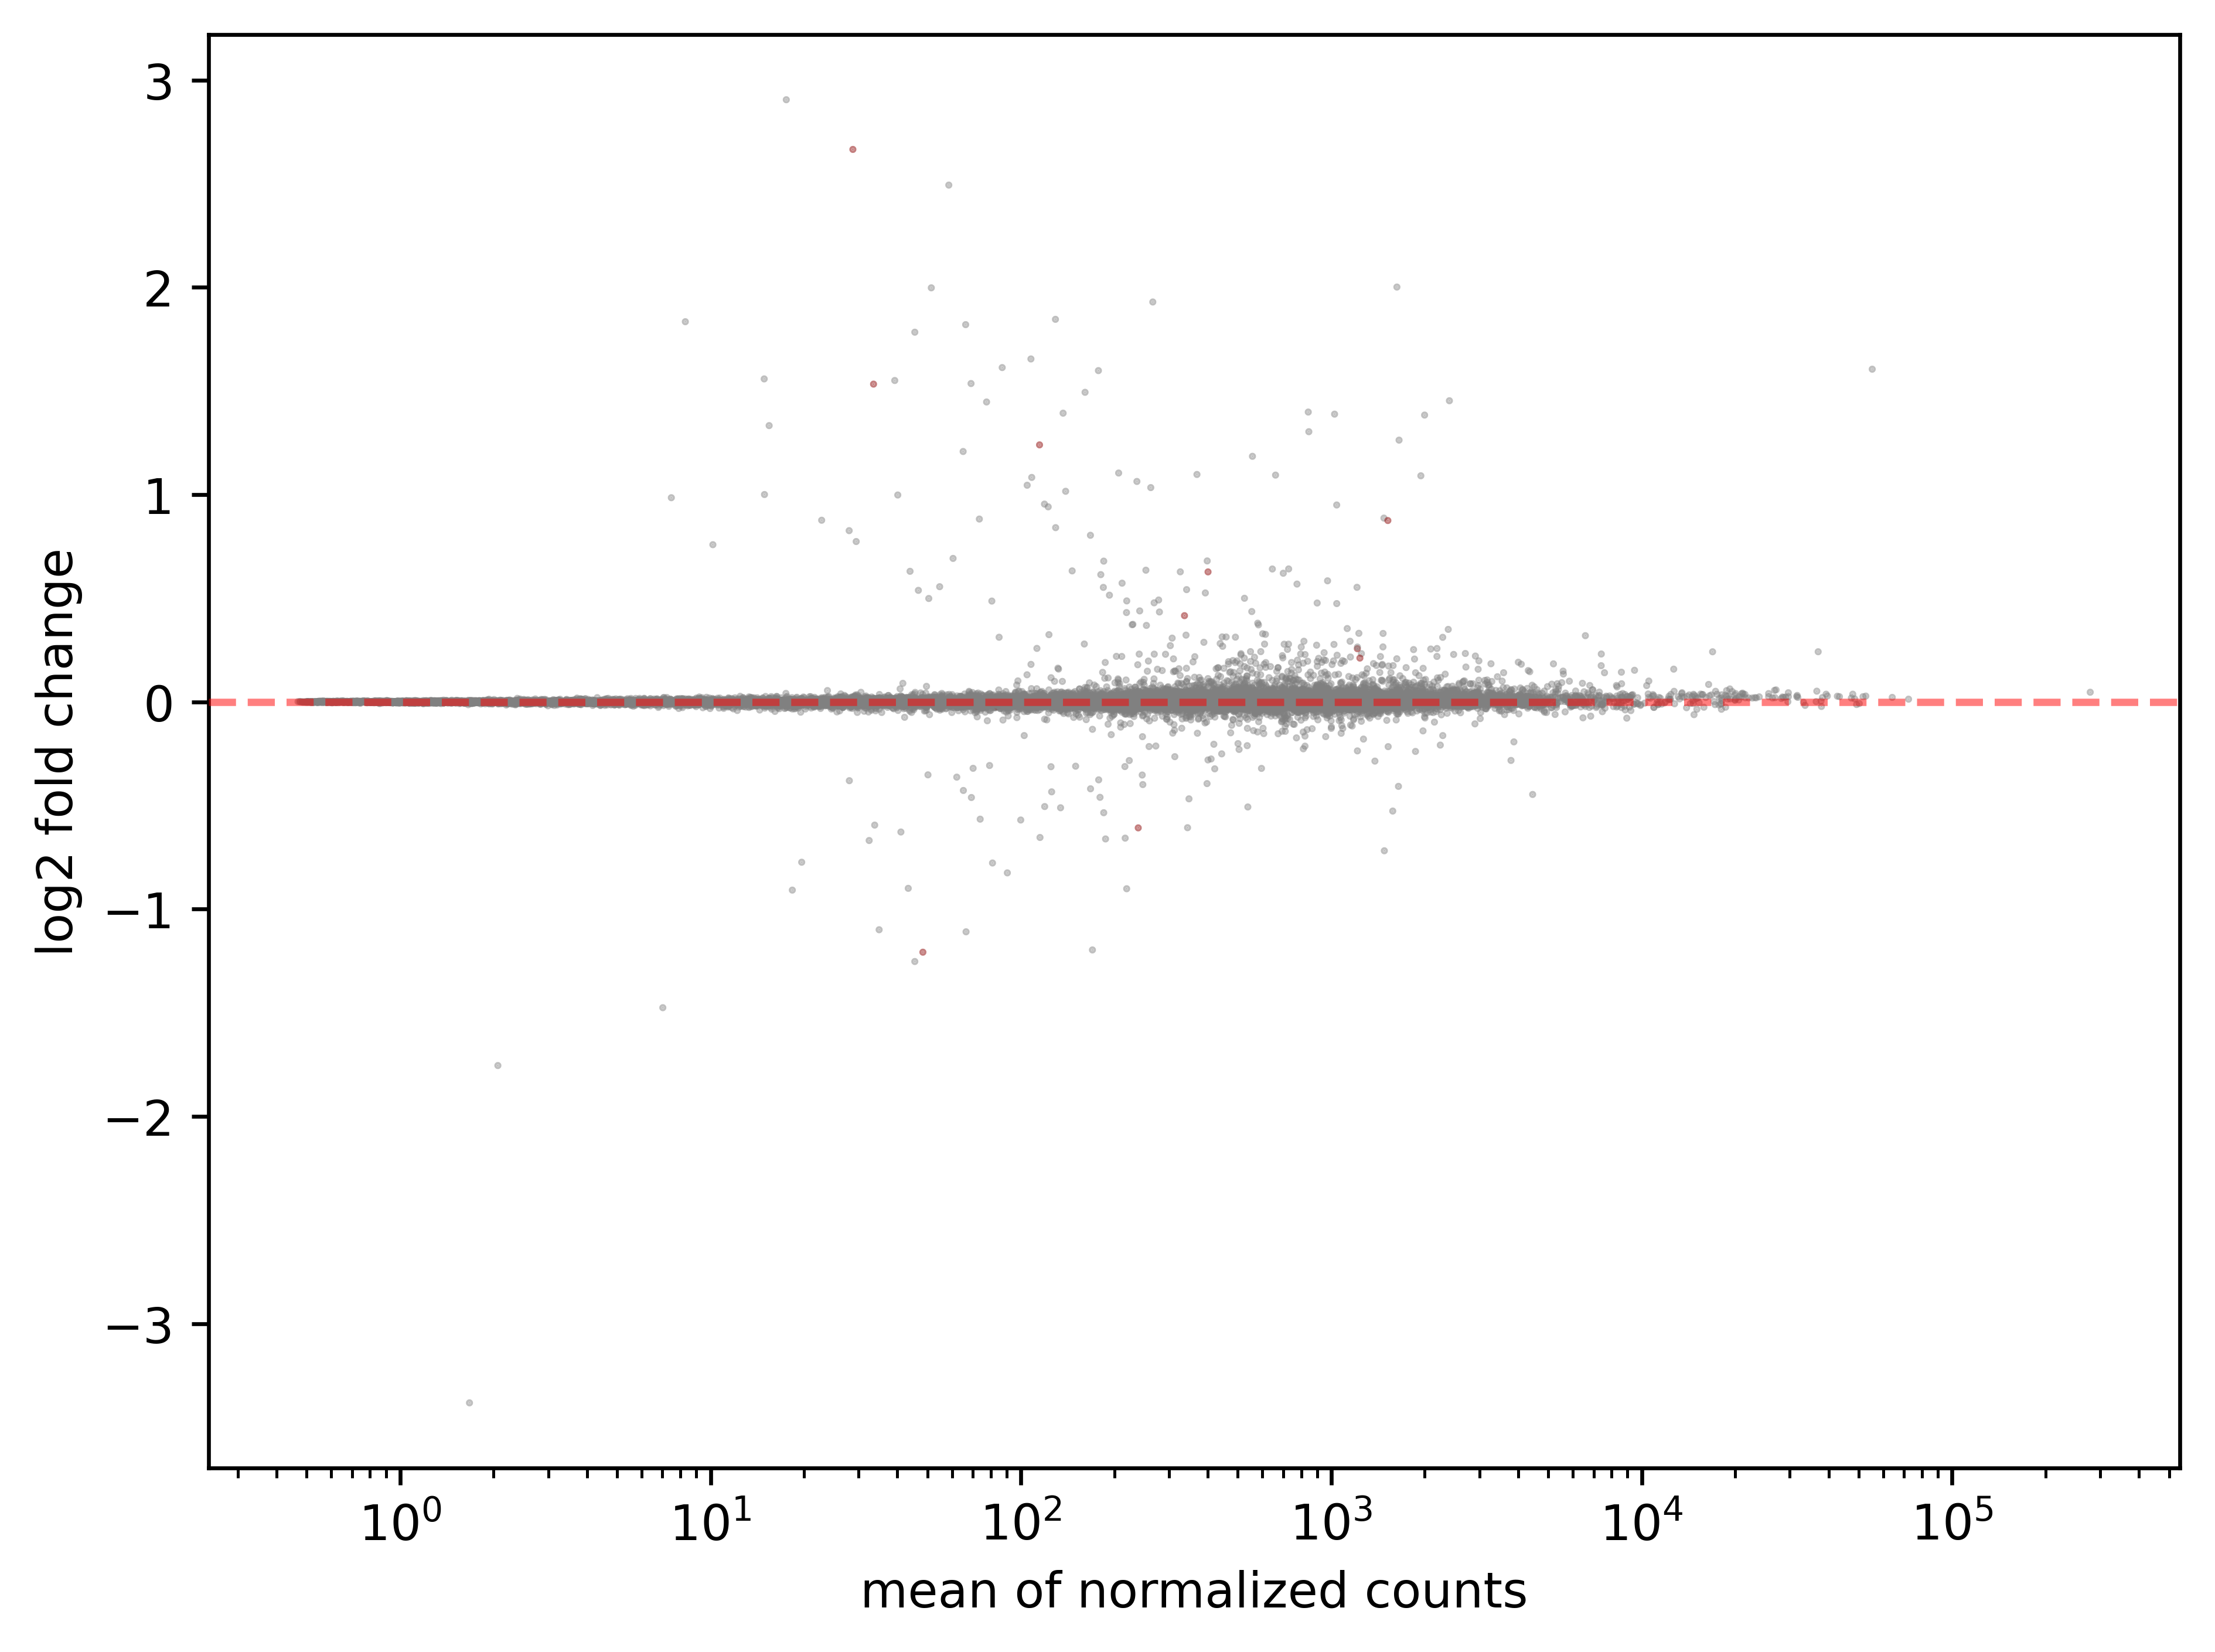

In [ ]:
ds.plot_MA(save_path="/content/drive/My Drive/BENG204_Project/BENG204_Project_Figures/")


We now generate a volcano plot for the Ho et al DEGs.

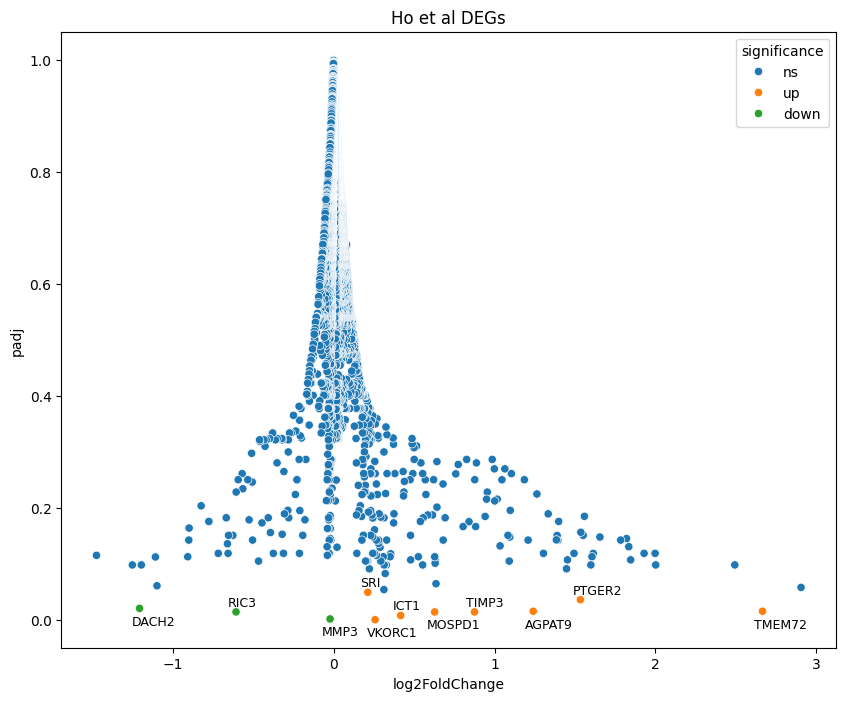

In [ ]:
plt.figure(figsize=(10, 8))
volcano = sns.scatterplot(ds_df, x = 'log2FoldChange', y = 'padj', hue='significance')
volcano.set_title("Ho et al DEGs")
DEGs = ["DACH2", "RIC3", "MMP3", "SRI", "VKORC1", "ICT1", "MOSPD1", "TIMP3", "AGPAT9", "PTGER2", "TMEM72"]
for i, row in DEGs_df.iterrows():
    if row['gene_symbol'] in DEGs:
      if i % 2 == 1:
        volcano.text(row['log2FoldChange']-0.05, row['padj']+0.01, row['gene_symbol'], fontsize=9)
      else:
        volcano.text(row['log2FoldChange']-0.05, row['padj']-0.03, row['gene_symbol'], fontsize=9)

Save the volcano plot:

In [ ]:
volcano.figure.savefig("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_volcano.png", dpi=300)